In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from matplotlib.colors import colorConverter, ListedColormap 
# 对于上面的fit可以这么扩展变成动态的
from sklearn.preprocessing import OneHotEncoder

In [2]:
def onehot(y,start,end):
    ohe = OneHotEncoder()
    a = np.linspace(start,end-1,end-start)
    b =np.reshape(a,[-1,1]).astype(np.int32)
    ohe.fit(b)
    c=ohe.transform(y).toarray()  
    return c  
    
def generate(sample_size, num_classes, diff,regression=False):
    np.random.seed(10)
    mean = np.random.randn(2)
    cov = np.eye(2)  
    
    #len(diff)
    samples_per_class = int(sample_size/num_classes)

    X0 = np.random.multivariate_normal(mean, cov, samples_per_class)
    Y0 = np.zeros(samples_per_class)
    
    for ci, d in enumerate(diff):
        X1 = np.random.multivariate_normal(mean+d, cov, samples_per_class)
        Y1 = (ci+1)*np.ones(samples_per_class)
    
        X0 = np.concatenate((X0,X1))
        Y0 = np.concatenate((Y0,Y1))

  
    if regression==False: #one-hot  0 into the vector "1 0
        Y0 = np.reshape(Y0,[-1,1])        
        #print(Y0.astype(np.int32))
        Y0 = onehot(Y0.astype(np.int32),0,num_classes)
        #print(Y0)
    X, Y = shuffle(X0, Y0)
    #print(X, Y)
    return X,Y   

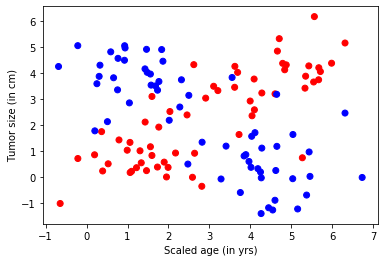

W1113 20:47:31.798957 140555595466496 deprecation.py:323] From /home/lx/.pyenv/versions/3.7.3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
np.random.seed(10)

input_dim = 2
num_classes =4 
X, Y = generate(120,num_classes,  [[3.0,0],[3.0,3.0],[0,3.0]],True)
Y=Y%2
colors = ['r' if l == 0.0 else 'b' for l in Y[:]]
plt.scatter(X[:,0], X[:,1], c=colors)
plt.xlabel("Scaled age (in yrs)")
plt.ylabel("Tumor size (in cm)")
plt.show() 
Y=np.reshape(Y,[-1,1])

learning_rate = 1e-4
n_input  = 2
n_label  = 1
n_hidden = 200


x = tf.placeholder(tf.float32, [None,n_input])
y = tf.placeholder(tf.float32, [None, n_label])

weights = {
    'h1': tf.Variable(tf.truncated_normal([n_input, n_hidden], stddev=0.1)),
    'h2': tf.Variable(tf.random_normal([n_hidden, n_label], stddev=0.1))
	} 
biases = {
    'h1': tf.Variable(tf.zeros([n_hidden])),
    'h2': tf.Variable(tf.zeros([n_label]))
    }    


layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['h1']), biases['h1']))

#Leaky relus  
layer2 =tf.add(tf.matmul(layer_1, weights['h2']),biases['h2'])
y_pred = tf.maximum(layer2,0.01*layer2)

reg = 0.01 
loss=tf.reduce_mean((y_pred-y)**2)+tf.nn.l2_loss(weights['h1'])*reg+tf.nn.l2_loss(weights['h2'])*reg
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Step: 0 Current loss: 0.34763196
Step: 1000 Current loss: 0.13035578
Step: 2000 Current loss: 0.11090168
Step: 3000 Current loss: 0.104148746
Step: 4000 Current loss: 0.10149408
Step: 5000 Current loss: 0.10038552
Step: 6000 Current loss: 0.09988807
Step: 7000 Current loss: 0.0996326
Step: 8000 Current loss: 0.09947153
Step: 9000 Current loss: 0.09936389
Step: 10000 Current loss: 0.09928761
Step: 11000 Current loss: 0.09923961
Step: 12000 Current loss: 0.09921081
Step: 13000 Current loss: 0.09919396
Step: 14000 Current loss: 0.09918459
Step: 15000 Current loss: 0.09917883
Step: 16000 Current loss: 0.09917461
Step: 17000 Current loss: 0.09917089
Step: 18000 Current loss: 0.09916765
Step: 19000 Current loss: 0.09916471
loss:
 0.09031449


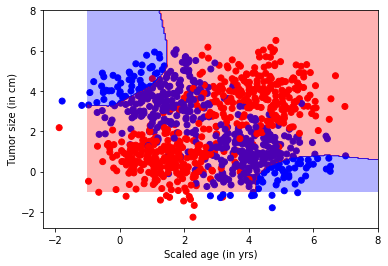

In [4]:
#加载
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
    
for i in range(20000):

    X, Y = generate(1000,num_classes,  [[3.0,0],[3.0,3.0],[0,3.0]],True)
    Y=Y%2
    Y=np.reshape(Y,[-1,1])
  
    _, loss_val = sess.run([train_step, loss], feed_dict={x: X, y: Y})
    
    if i % 1000 == 0:
        print ("Step:", i, "Current loss:", loss_val)

colors = ['r' if l == 0.0 else 'b' for l in Y[:]]
plt.scatter(X[:,0], X[:,1], c=colors)
plt.xlabel("Scaled age (in yrs)")
plt.ylabel("Tumor size (in cm)")

    
nb_of_xs = 200
xs1 = np.linspace(-1, 8, num=nb_of_xs)
xs2 = np.linspace(-1, 8, num=nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        #classification_plane[i,j] = nn_predict(xx[i,j], yy[i,j])
        classification_plane[i,j] = sess.run(y_pred, feed_dict={x: [[ xx[i,j], yy[i,j] ]]} )
        classification_plane[i,j] = int(classification_plane[i,j])

# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('r', alpha=0.30),
        colorConverter.to_rgba('b', alpha=0.30)])
# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
plt.show() 


xTrain, yTrain = generate(12,num_classes,  [[3.0,0],[3.0,3.0],[0,3.0]],True)
yTrain=yTrain%2
colors = ['r' if l == 0.0 else 'b' for l in yTrain[:]]
plt.scatter(xTrain[:,0], xTrain[:,1], c=colors)
plt.xlabel("Scaled age (in yrs)")
plt.ylabel("Tumor size (in cm)")
#plt.show() 
yTrain=np.reshape(yTrain,[-1,1])           
print ("loss:\n", sess.run(loss, feed_dict={x: xTrain, y: yTrain}))          

nb_of_xs = 200
xs1 = np.linspace(-1, 8, num=nb_of_xs)
xs2 = np.linspace(-1, 8, num=nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        #classification_plane[i,j] = nn_predict(xx[i,j], yy[i,j])
        classification_plane[i,j] = sess.run(y_pred, feed_dict={x: [[ xx[i,j], yy[i,j] ]]} )
        classification_plane[i,j] = int(classification_plane[i,j])

# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('r', alpha=0.30),
        colorConverter.to_rgba('b', alpha=0.30)])
# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
plt.show() 